# 1. Importing libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder # not needed
from sklearn.model_selection import train_test_split
# from sklearn.model_selection import GridSearchCV

import keras
from keras.models import Sequential
from keras.layers import Dense

from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [2]:
data_path = ""
# maybe remember to install tensorflow with the version I have here

# 2. Loading the dataset

In [3]:
# link: 
df = pd.read_excel(data_path+"dataset/Dry_Bean_Dataset.xlsx")
df.head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272750,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER


In [4]:
df.isnull().sum().sum()

0

# 3. Train/test splitting and normalization

In [5]:
df_columns = list(df.columns)
df_columns.remove('Class')
# df_columns.remove('id')
features = df_columns
print(features)

['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength', 'AspectRation', 'Eccentricity', 'ConvexArea', 'EquivDiameter', 'Extent', 'Solidity', 'roundness', 'Compactness', 'ShapeFactor1', 'ShapeFactor2', 'ShapeFactor3', 'ShapeFactor4']


In [6]:
X = df[features]
y = df['Class']

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

encoder = LabelEncoder()
y_num = encoder.fit_transform(y)
y_one_hot = pd.get_dummies(y)

indices = np.arange(len(X))

(
    X_train, 
    X_test, 
    y_train, 
    y_test, 
    train_indices, 
    test_indices)= train_test_split(X, y, indices, test_size = 0.3, random_state = 40)

y_train_num = y_num[train_indices]
y_test_num = y_num[test_indices]

y_train_one_hot = y_one_hot.iloc[train_indices]
y_test_one_hot = y_one_hot.iloc[test_indices]

# 4. Accuracy report function

In [7]:
def accuracy_report(y_test, y_pred):
    cm = confusion_matrix(y_test,y_pred)
    acc_report = {}
    labels = np.unique(y_test)
    AA = 0
    for label in labels:
        per_class_acc = cm[label,label]/np.sum(cm[label,:]) * 100
        acc_report["class " + str(label)] = per_class_acc
        AA+=per_class_acc
    AA = AA/len(labels)
    acc_report["OA"] = accuracy_score(y_test, y_pred)*100
    acc_report["AA"] = AA
    
    return acc_report

# 5. Artificial Neural Network Classification
## 5.1.  hidden nodes = 32

## 5.1.1. Building the network

In [141]:
LR = 0.0001

In [142]:
N_input = X_train.shape[1]
N_output = y_train_one_hot.shape[1]

ann_model = Sequential()
ann_model.add(Dense(N_input*2, input_dim=N_input, activation='relu'))
ann_model.add(Dense(N_output, activation='softmax'))

optim = keras.optimizers.Adam(lr=LR)
ann_model.compile(loss='binary_crossentropy', optimizer=optim, metrics=['accuracy']) # is binary_cross right?
ann_model.summary()

# saving the weights
ann_model.save_weights(data_path + "data/weights/ann_initial_weights.h5")

# say that the architecture, especially the number of hidden nodes play an important role in the classification acc

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 32)                544       
_________________________________________________________________
dense_25 (Dense)             (None, 7)                 231       
Total params: 775
Trainable params: 775
Non-trainable params: 0
_________________________________________________________________


## 5.1.2. Training the network

In [194]:
# explain epochs
epochs=500 # try incrementing the number of epochs. 100>> 10. 500 seems to get traing acc stable
batch_size=10 # try changing the batch size and showing that 10 is better than 50

In [195]:
# we need to load weights so that we can always start from the beginning because if we train the network twice
# the second time it will start from the weights of the last time
# talk about both accuracy and loss
ann_model.load_weights(data_path + "data/weights/ann_initial_weights.h5")
history = ann_model.fit(X_train, y_train_one_hot, epochs=epochs, batch_size=batch_size)
# save weights after training
ann_model.save_weights(data_path + "data/weights/ann_trained_weights_num_epochs_"+str(epochs)+".h5")
np.save(data_path + "data/training accuracy/ann_training_acc_epochs_"+str(epochs), history.history['accuracy'])
np.save(data_path + "data/training loss/ann_training_loss_epochs_"+str(epochs), history.history['loss'])

Epoch 1/10
953/953 [==============================] - 1s 949us/step - loss: 0.4403 - accuracy: 0.2401
Epoch 2/10
953/953 [==============================] - 1s 947us/step - loss: 0.3692 - accuracy: 0.2597
Epoch 3/10
953/953 [==============================] - 1s 955us/step - loss: 0.3468 - accuracy: 0.2901
Epoch 4/10
953/953 [==============================] - 1s 943us/step - loss: 0.3232 - accuracy: 0.4229
Epoch 5/10
953/953 [==============================] - 1s 952us/step - loss: 0.2998 - accuracy: 0.5014
Epoch 6/10
953/953 [==============================] - 1s 1ms/step - loss: 0.2797 - accuracy: 0.5956
Epoch 7/10
953/953 [==============================] - 1s 984us/step - loss: 0.2622 - accuracy: 0.6944
Epoch 8/10
953/953 [==============================] - 1s 932us/step - loss: 0.2460 - accuracy: 0.7601
Epoch 9/10
953/953 [==============================] - 1s 1ms/step - loss: 0.2327 - accuracy: 0.7926
Epoch 10/10
953/953 [==============================] - 1s 923us/step - loss: 0.2212 - 

## 5.1.3. Plotting training performance

In [233]:
training_acc = np.load(data_path + "data/training_acc_epochs_"+str(epochs)+".npy")
training_loss = np.load(data_path + "data/training_loss_epochs_"+str(epochs)+".npy")
# training_acc

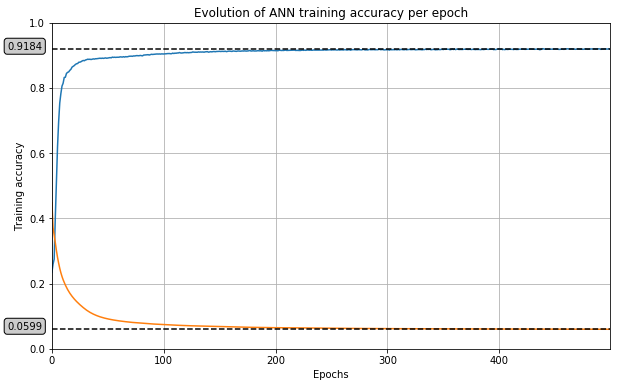

In [236]:
plt.figure(figsize=(10,6))
plt.plot(training_acc)
plt.plot(training_loss)
plt.plot(np.ones(len(training_acc))*training_acc[-1], color='k',linestyle = 'dashed')
plt.plot(np.ones(len(training_loss))*training_loss[-1], color='k',linestyle = 'dashed')

bbox = dict(boxstyle ="round", fc ="0.8")
plt.annotate("{:.4f}".format(training_acc[-1]), 
             xy =(0, training_acc[-1]),
             xytext =(-40, training_acc[-1]), 
             bbox=bbox)
plt.annotate("{:.4f}".format(training_loss[-1]), 
             xy =(0, training_loss[-1]),
             xytext =(-40, training_loss[-1]), 
             bbox=bbox)
plt.xlim([0, epochs-1])
plt.ylim([0, 1])
plt.xlabel("Epochs")
plt.ylabel("Training accuracy")
plt.title("Evolution of ANN training accuracy per epoch")
plt.grid()
plt.show()

# add index for acc and loss

## 5.1.4. Testing the network

##### a. Getting the prediction array

In [146]:
# ann_model.save_weights(data_path + "data/ann_trained_weights.h5")
y_ann_pred = ann_model.predict(X_test)

##### b. Normalizing the prediction array

In [147]:
y_oh_pred = []
for i in range(len(y_ann_pred)):
    pred = y_ann_pred[i]
    pred_max = np.max(y_ann_pred[i])
    y_oh_pred.append(list(np.where(pred== pred_max, 1, 0)))
# y_oh_pred = np.array(y_oh_pred)
# using list comprehension
# y_oh_pred = [[1 if pred == np.max(y_ann_pred[i]) else 0 for pred in y_ann_pred[i]] for i in range(len(y_ann_pred))]
# y_oh_pred = np.array(y_oh_pred)

##### b. Decoding the one-hot prediction array and displaying the accuracy report

In [148]:
y_pred_num = [y_oh_pred[i].index(1) for i in range(len(y_oh_pred))]
acc_report = accuracy_report(y_test_num, y_pred_num)
acc_report_df = pd.DataFrame(data=[round(acc,2) for acc in acc_report.values()], 
                             index=acc_report.keys(), 
                             columns=["ANN accuracy (%)"])
acc_report_df

,ANN accuracy (%)
class 0,91.67
class 1,100.00
class 2,95.59
class 3,92.58
class 4,94.75
class 5,93.86
class 6,85.59
OA,92.21
AA,93.43


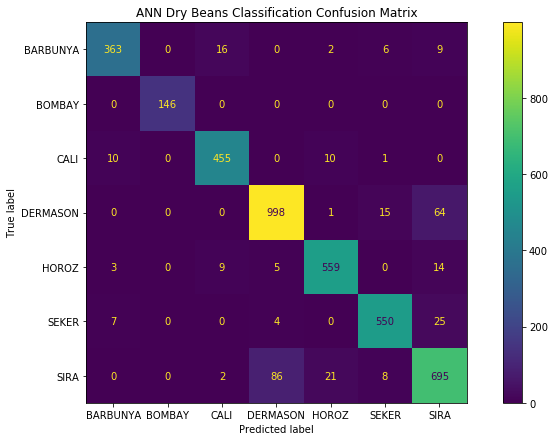

In [149]:
y_pred = encoder.inverse_transform(y_pred_num)
cm_ann = confusion_matrix(y_test,y_pred)
cm_ann = confusion_matrix(y_test, y_pred, labels=np.unique(y))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_ann,display_labels=np.unique(y))
_, ax = plt.subplots(figsize=(13, 7))
disp.plot(ax=ax)
plt.title("ANN Dry Beans Classification Confusion Matrix")
plt.show()

## 5.2.  Increasing the number of epochs

In [8]:
perform_per_num_epochs = pd.DataFrame(columns=["epochs", "loss", "training acc (%)","test acc (%)"])
perform_per_num_epochs

,epochs,loss,training acc (%),test acc (%)


In [11]:
mul_layer = 2
N_input = X_train.shape[1]
N_output = y_train_one_hot.shape[1]
LR = 0.0001
batch_size=10

for epochs in [10, 50, 100, 200, 500, 700, 1000]:
    ann_model2 = Sequential()
    ann_model2.add(Dense(N_input*mul_layer, input_dim=N_input, activation='relu'))
    ann_model2.add(Dense(N_output, activation='softmax'))
    optim = keras.optimizers.Adam(lr=LR)
    ann_model2.compile(loss='binary_crossentropy', optimizer=optim, metrics=['accuracy']) # is binary_cross right?
    history = ann_model2.fit(X_train, y_train_one_hot, epochs=epochs, batch_size=batch_size)
    training_acc = history.history["accuracy"]
    training_loss = history.history["loss"]

    y_ann_pred = ann_model2.predict(X_test)
    y_oh_pred = [[1 if pred == np.max(y_ann_pred[i]) else 0 for pred in y_ann_pred[i]] for i in range(len(y_ann_pred))]
    y_pred_num = [y_oh_pred[i].index(1) for i in range(len(y_oh_pred))]
    test_acc = accuracy_score(y_test_num, y_pred_num)*100

    perform_per_num_epochs = perform_per_num_epochs.append({ 
        "epochs": str(int(epochs)), 
        "loss": round(training_loss[-1], 4), 
        "training acc (%)": round(training_acc[-1]*100, 2), 
        "test acc (%)": round(test_acc, 2)},ignore_index = True)
    ann_model2.save_weights(data_path + "ann2/weights/ann_trained_weights_num_epochs_"+str(epochs)+".h5")
    np.save(data_path + "ann2/training accuracy/ann_training_acc_epochs_"+str(epochs), history.history['accuracy'])
    np.save(data_path + "ann2/training loss/ann_training_loss_epochs_"+str(epochs), history.history['loss'])

Epoch 1/700
953/953 [==============================] - 1s 1ms/step - loss: 0.3743 - accuracy: 0.2988
Epoch 2/700
953/953 [==============================] - 1s 1ms/step - loss: 0.3303 - accuracy: 0.3931
Epoch 3/700
953/953 [==============================] - 1s 1ms/step - loss: 0.2945 - accuracy: 0.4758
Epoch 4/700
953/953 [==============================] - 1s 1ms/step - loss: 0.2632 - accuracy: 0.6151
Epoch 5/700
953/953 [==============================] - 1s 957us/step - loss: 0.2358 - accuracy: 0.7076
Epoch 6/700
953/953 [==============================] - 1s 902us/step - loss: 0.2119 - accuracy: 0.7604
Epoch 7/700
953/953 [==============================] - 1s 885us/step - loss: 0.1907 - accuracy: 0.8094
Epoch 8/700
953/953 [==============================] - 1s 885us/step - loss: 0.1729 - accuracy: 0.8388
Epoch 9/700
953/953 [==============================] - 1s 1ms/step - loss: 0.1584 - accuracy: 0.8562
Epoch 10/700
953/953 [==============================] - 1s 1ms/step - loss: 0.1466 

953/953 [==============================] - 1s 951us/step - loss: 0.0622 - accuracy: 0.9158
Epoch 156/700
953/953 [==============================] - 1s 951us/step - loss: 0.0622 - accuracy: 0.9167
Epoch 157/700
953/953 [==============================] - 1s 967us/step - loss: 0.0621 - accuracy: 0.9150
Epoch 158/700
953/953 [==============================] - 1s 926us/step - loss: 0.0621 - accuracy: 0.9154
Epoch 159/700
953/953 [==============================] - 1s 918us/step - loss: 0.0620 - accuracy: 0.9161
Epoch 160/700
953/953 [==============================] - 1s 918us/step - loss: 0.0620 - accuracy: 0.9170
Epoch 161/700
953/953 [==============================] - 1s 1ms/step - loss: 0.0619 - accuracy: 0.9156
Epoch 162/700
953/953 [==============================] - 1s 1ms/step - loss: 0.0618 - accuracy: 0.9160
Epoch 163/700
953/953 [==============================] - 1s 951us/step - loss: 0.0619 - accuracy: 0.9153
Epoch 164/700
953/953 [==============================] - 1s 926us/step - 

953/953 [==============================] - 1s 885us/step - loss: 0.0586 - accuracy: 0.9188
Epoch 311/700
953/953 [==============================] - 1s 885us/step - loss: 0.0585 - accuracy: 0.9195
Epoch 312/700
953/953 [==============================] - 1s 867us/step - loss: 0.0585 - accuracy: 0.9194
Epoch 313/700
953/953 [==============================] - 1s 869us/step - loss: 0.0586 - accuracy: 0.9194
Epoch 314/700
953/953 [==============================] - 1s 935us/step - loss: 0.0584 - accuracy: 0.9197
Epoch 315/700
953/953 [==============================] - 1s 902us/step - loss: 0.0585 - accuracy: 0.9200
Epoch 316/700
953/953 [==============================] - 1s 902us/step - loss: 0.0585 - accuracy: 0.9201
Epoch 317/700
953/953 [==============================] - 1s 918us/step - loss: 0.0585 - accuracy: 0.9203
Epoch 318/700
953/953 [==============================] - 1s 1ms/step - loss: 0.0585 - accuracy: 0.9197
Epoch 319/700
953/953 [==============================] - 1s 1ms/step - 

953/953 [==============================] - 1s 967us/step - loss: 0.0578 - accuracy: 0.9208
Epoch 389/700
953/953 [==============================] - 1s 926us/step - loss: 0.0578 - accuracy: 0.9219
Epoch 390/700
953/953 [==============================] - 1s 918us/step - loss: 0.0578 - accuracy: 0.9209
Epoch 391/700
953/953 [==============================] - 1s 935us/step - loss: 0.0578 - accuracy: 0.9216
Epoch 392/700
953/953 [==============================] - 1s 918us/step - loss: 0.0578 - accuracy: 0.9214
Epoch 393/700
953/953 [==============================] - 1s 918us/step - loss: 0.0576 - accuracy: 0.9208
Epoch 394/700
953/953 [==============================] - 1s 935us/step - loss: 0.0578 - accuracy: 0.9212
Epoch 395/700
953/953 [==============================] - 1s 918us/step - loss: 0.0577 - accuracy: 0.9215
Epoch 396/700
953/953 [==============================] - 1s 918us/step - loss: 0.0577 - accuracy: 0.9212
Epoch 397/700
953/953 [==============================] - 1s 935us/ste

Epoch 542/700
953/953 [==============================] - 1s 885us/step - loss: 0.0567 - accuracy: 0.9229
Epoch 543/700
953/953 [==============================] - 1s 918us/step - loss: 0.0567 - accuracy: 0.9233
Epoch 544/700
953/953 [==============================] - 1s 984us/step - loss: 0.0567 - accuracy: 0.9226
Epoch 545/700
953/953 [==============================] - 1s 918us/step - loss: 0.0566 - accuracy: 0.9236
Epoch 546/700
953/953 [==============================] - 1s 935us/step - loss: 0.0566 - accuracy: 0.9233
Epoch 547/700
953/953 [==============================] - 1s 935us/step - loss: 0.0566 - accuracy: 0.9238
Epoch 548/700
953/953 [==============================] - 1s 951us/step - loss: 0.0567 - accuracy: 0.9233
Epoch 549/700
953/953 [==============================] - 1s 935us/step - loss: 0.0566 - accuracy: 0.9234
Epoch 550/700
953/953 [==============================] - 1s 967us/step - loss: 0.0566 - accuracy: 0.9236
Epoch 551/700
953/953 [==============================] 

953/953 [==============================] - 1s 967us/step - loss: 0.0557 - accuracy: 0.9236
Epoch 697/700
953/953 [==============================] - 1s 902us/step - loss: 0.0558 - accuracy: 0.9241
Epoch 698/700
953/953 [==============================] - 1s 951us/step - loss: 0.0558 - accuracy: 0.9236
Epoch 699/700
953/953 [==============================] - 1s 933us/step - loss: 0.0557 - accuracy: 0.9250
Epoch 700/700
953/953 [==============================] - 1s 935us/step - loss: 0.0558 - accuracy: 0.9233
Epoch 1/1000
953/953 [==============================] - 1s 1ms/step - loss: 0.3832 - accuracy: 0.2578: 0s - loss: 0.392
Epoch 2/1000
953/953 [==============================] - 1s 1ms/step - loss: 0.3457 - accuracy: 0.3537
Epoch 3/1000
953/953 [==============================] - 1s 925us/step - loss: 0.3111 - accuracy: 0.4544
Epoch 4/1000
953/953 [==============================] - 1s 921us/step - loss: 0.2779 - accuracy: 0.5793
Epoch 5/1000
953/953 [==============================] - 1s 

953/953 [==============================] - 1s 935us/step - loss: 0.0700 - accuracy: 0.9047
Epoch 74/1000
953/953 [==============================] - 1s 1ms/step - loss: 0.0699 - accuracy: 0.9049
Epoch 75/1000
953/953 [==============================] - 1s 1ms/step - loss: 0.0697 - accuracy: 0.9043
Epoch 76/1000
953/953 [==============================] - 1s 935us/step - loss: 0.0695 - accuracy: 0.9046
Epoch 77/1000
953/953 [==============================] - 1s 1ms/step - loss: 0.0693 - accuracy: 0.9058
Epoch 78/1000
953/953 [==============================] - 1s 935us/step - loss: 0.0692 - accuracy: 0.9057
Epoch 79/1000
953/953 [==============================] - 1s 918us/step - loss: 0.0691 - accuracy: 0.9054
Epoch 80/1000
953/953 [==============================] - 1s 918us/step - loss: 0.0690 - accuracy: 0.9062
Epoch 81/1000
953/953 [==============================] - 1s 935us/step - loss: 0.0688 - accuracy: 0.9056
Epoch 82/1000
953/953 [==============================] - 1s 967us/step - lo

953/953 [==============================] - 1s 935us/step - loss: 0.0607 - accuracy: 0.9174
Epoch 228/1000
953/953 [==============================] - 1s 986us/step - loss: 0.0606 - accuracy: 0.9172
Epoch 229/1000
953/953 [==============================] - 1s 932us/step - loss: 0.0606 - accuracy: 0.9170
Epoch 230/1000
953/953 [==============================] - 1s 951us/step - loss: 0.0605 - accuracy: 0.9164
Epoch 231/1000
953/953 [==============================] - 1s 935us/step - loss: 0.0606 - accuracy: 0.91720s - loss: 0.0
Epoch 232/1000
953/953 [==============================] - 1s 918us/step - loss: 0.0605 - accuracy: 0.9174
Epoch 233/1000
953/953 [==============================] - 1s 1ms/step - loss: 0.0606 - accuracy: 0.9166
Epoch 234/1000
953/953 [==============================] - 1s 918us/step - loss: 0.0606 - accuracy: 0.9167
Epoch 235/1000
953/953 [==============================] - 1s 902us/step - loss: 0.0605 - accuracy: 0.9174
Epoch 236/1000
953/953 [=========================

953/953 [==============================] - 1s 869us/step - loss: 0.0589 - accuracy: 0.9211
Epoch 382/1000
953/953 [==============================] - 1s 869us/step - loss: 0.0590 - accuracy: 0.9185
Epoch 383/1000
953/953 [==============================] - 1s 869us/step - loss: 0.0590 - accuracy: 0.9189
Epoch 384/1000
953/953 [==============================] - 1s 869us/step - loss: 0.0589 - accuracy: 0.9208
Epoch 385/1000
953/953 [==============================] - 1s 885us/step - loss: 0.0590 - accuracy: 0.9191
Epoch 386/1000
953/953 [==============================] - 1s 885us/step - loss: 0.0589 - accuracy: 0.9198
Epoch 387/1000
953/953 [==============================] - 1s 885us/step - loss: 0.0589 - accuracy: 0.9200
Epoch 388/1000
953/953 [==============================] - 1s 869us/step - loss: 0.0589 - accuracy: 0.9192
Epoch 389/1000
953/953 [==============================] - 1s 869us/step - loss: 0.0589 - accuracy: 0.9195
Epoch 390/1000
953/953 [==============================] - 1s 

953/953 [==============================] - 1s 1ms/step - loss: 0.0581 - accuracy: 0.9214
Epoch 536/1000
953/953 [==============================] - 1s 1ms/step - loss: 0.0580 - accuracy: 0.9214
Epoch 537/1000
953/953 [==============================] - 1s 902us/step - loss: 0.0580 - accuracy: 0.9213
Epoch 538/1000
953/953 [==============================] - 1s 902us/step - loss: 0.0580 - accuracy: 0.9201
Epoch 539/1000
953/953 [==============================] - 1s 1ms/step - loss: 0.0580 - accuracy: 0.9217
Epoch 540/1000
953/953 [==============================] - 1s 885us/step - loss: 0.0580 - accuracy: 0.9201
Epoch 541/1000
953/953 [==============================] - 1s 869us/step - loss: 0.0580 - accuracy: 0.9209
Epoch 542/1000
953/953 [==============================] - 1s 869us/step - loss: 0.0580 - accuracy: 0.9212
Epoch 543/1000
953/953 [==============================] - 1s 885us/step - loss: 0.0580 - accuracy: 0.9203
Epoch 544/1000
953/953 [==============================] - 1s 869us/

953/953 [==============================] - 1s 885us/step - loss: 0.0575 - accuracy: 0.9205
Epoch 613/1000
953/953 [==============================] - 1s 869us/step - loss: 0.0576 - accuracy: 0.9216
Epoch 614/1000
953/953 [==============================] - 1s 869us/step - loss: 0.0575 - accuracy: 0.9220
Epoch 615/1000
953/953 [==============================] - 1s 885us/step - loss: 0.0576 - accuracy: 0.9212
Epoch 616/1000
953/953 [==============================] - 1s 869us/step - loss: 0.0575 - accuracy: 0.9216
Epoch 617/1000
953/953 [==============================] - 1s 869us/step - loss: 0.0575 - accuracy: 0.9213
Epoch 618/1000
953/953 [==============================] - 1s 885us/step - loss: 0.0576 - accuracy: 0.9214
Epoch 619/1000
953/953 [==============================] - 1s 885us/step - loss: 0.0575 - accuracy: 0.9204
Epoch 620/1000
953/953 [==============================] - 1s 885us/step - loss: 0.0575 - accuracy: 0.9211
Epoch 621/1000
953/953 [==============================] - 1s 

953/953 [==============================] - 1s 869us/step - loss: 0.0568 - accuracy: 0.9226
Epoch 766/1000
953/953 [==============================] - 1s 885us/step - loss: 0.0568 - accuracy: 0.9233
Epoch 767/1000
953/953 [==============================] - 1s 869us/step - loss: 0.0568 - accuracy: 0.9231
Epoch 768/1000
953/953 [==============================] - 1s 885us/step - loss: 0.0569 - accuracy: 0.9236
Epoch 769/1000
953/953 [==============================] - 1s 885us/step - loss: 0.0568 - accuracy: 0.9239
Epoch 770/1000
953/953 [==============================] - 1s 885us/step - loss: 0.0568 - accuracy: 0.9234
Epoch 771/1000
953/953 [==============================] - 1s 902us/step - loss: 0.0568 - accuracy: 0.9231
Epoch 772/1000
953/953 [==============================] - 1s 885us/step - loss: 0.0568 - accuracy: 0.9227
Epoch 773/1000
953/953 [==============================] - 1s 869us/step - loss: 0.0568 - accuracy: 0.9239
Epoch 774/1000
953/953 [==============================] - 1s 

953/953 [==============================] - 1s 885us/step - loss: 0.0562 - accuracy: 0.9237
Epoch 920/1000
953/953 [==============================] - 1s 869us/step - loss: 0.0562 - accuracy: 0.9230
Epoch 921/1000
953/953 [==============================] - 1s 885us/step - loss: 0.0562 - accuracy: 0.9241
Epoch 922/1000
953/953 [==============================] - 1s 869us/step - loss: 0.0562 - accuracy: 0.9236
Epoch 923/1000
953/953 [==============================] - 1s 869us/step - loss: 0.0562 - accuracy: 0.9239
Epoch 924/1000
953/953 [==============================] - 1s 869us/step - loss: 0.0562 - accuracy: 0.9244
Epoch 925/1000
953/953 [==============================] - 1s 885us/step - loss: 0.0562 - accuracy: 0.9235
Epoch 926/1000
953/953 [==============================] - 1s 885us/step - loss: 0.0562 - accuracy: 0.9236
Epoch 927/1000
953/953 [==============================] - 1s 869us/step - loss: 0.0562 - accuracy: 0.9242
Epoch 928/1000
953/953 [==============================] - 1s 

##### Visualizing the performances

In [8]:
perform_per_num_epochs = pd.DataFrame(columns=["epochs", "loss", "training acc (%)","test acc (%)"])
training_acc_per_num_epochs = []
training_loss_per_num_epochs = []

In [9]:
mul_layer = 2
N_input = X_train.shape[1]
N_output = y_train_one_hot.shape[1]
LR = 0.0001
for epochs in [10, 50, 100, 200, 500, 700, 1000]:
    ann_model2 = Sequential()
    ann_model2.add(Dense(N_input*mul_layer, input_dim=N_input, activation='relu'))
    ann_model2.add(Dense(N_output, activation='softmax'))
    optim = keras.optimizers.Adam(lr=LR)
    ann_model2.compile(loss='binary_crossentropy', optimizer=optim, metrics=['accuracy'])
    ann_model2.load_weights(data_path + "ann2/weights/ann_trained_weights_num_epochs_"+str(epochs)+".h5")
    training_acc = np.load(data_path + "ann2/training accuracy/ann_training_acc_epochs_"+str(epochs)+".npy")
    training_loss = np.load(data_path + "ann2/training loss/ann_training_loss_epochs_"+str(epochs)+".npy")
    training_acc_per_num_epochs.append(training_acc)
    training_loss_per_num_epochs.append(training_loss)
    y_ann_pred = ann_model2.predict(X_test)
    y_oh_pred = [[1 if pred == np.max(y_ann_pred[i]) else 0 for pred in y_ann_pred[i]] for i in range(len(y_ann_pred))]
    y_pred_num = [y_oh_pred[i].index(1) for i in range(len(y_oh_pred))]
    test_acc = accuracy_score(y_test_num, y_pred_num)*100

    perform_per_num_epochs = perform_per_num_epochs.append({ 
        "epochs": str(int(epochs)), 
        "loss": round(training_loss[-1], 4), 
        "training acc (%)": round(training_acc[-1]*100, 2), 
        "test acc (%)": round(test_acc, 2)},ignore_index = True)
perform_per_num_epochs

,epochs,loss,training acc (%),test acc (%)
0,10,0.1537,86.64,85.58
1,50,0.0774,89.51,89.30
2,100,0.0699,90.54,90.45
3,200,0.0620,91.45,91.77
4,500,0.0582,92.00,92.29
5,700,0.0558,92.33,92.24
6,1000,0.0559,92.38,92.38


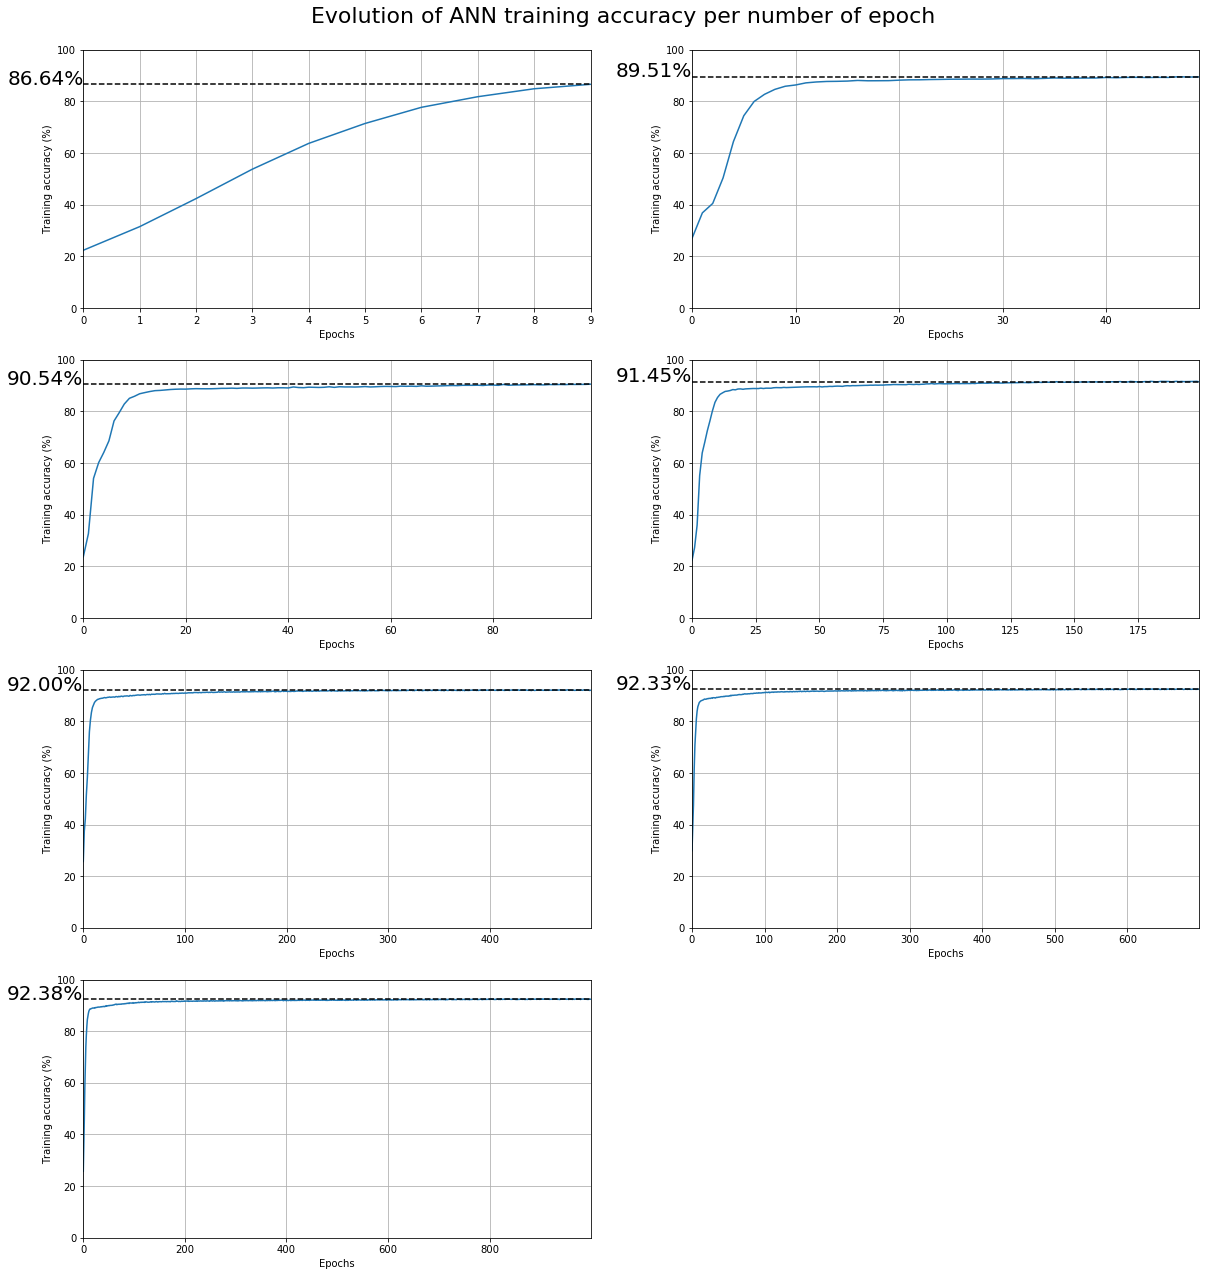

In [26]:
fig, (ax) = plt.subplots(4, 2, figsize=(20,20))
i=0
for ax_1 in ax:
    for ax_2 in ax_1:
        if i<7:
            training_acc = training_acc_per_num_epochs[i]
            ax_2.plot(training_acc*100)
            ax_2.plot(np.ones(len(training_acc))*training_acc[-1]*100, color='k',linestyle = 'dashed')
            ax_2.set_xlim([0, len(training_acc)-1])
            ax_2.set_ylim([0, 100])
            ax_2.text(-0.15, training_acc[-1], "{:.2f}".format(training_acc[-1]*100)+"%", 
                      transform=ax_2.transAxes, size=20)
            ax_2.set_xlabel("Epochs")
            ax_2.set_ylabel("Training accuracy (%)")
            ax_2.grid()
            i+=1
        else:
            ax_2.set_visible(False)
fig.subplots_adjust(top=0.95)
fig.suptitle("Evolution of ANN training accuracy per number of epoch", fontsize=22)
plt.show()

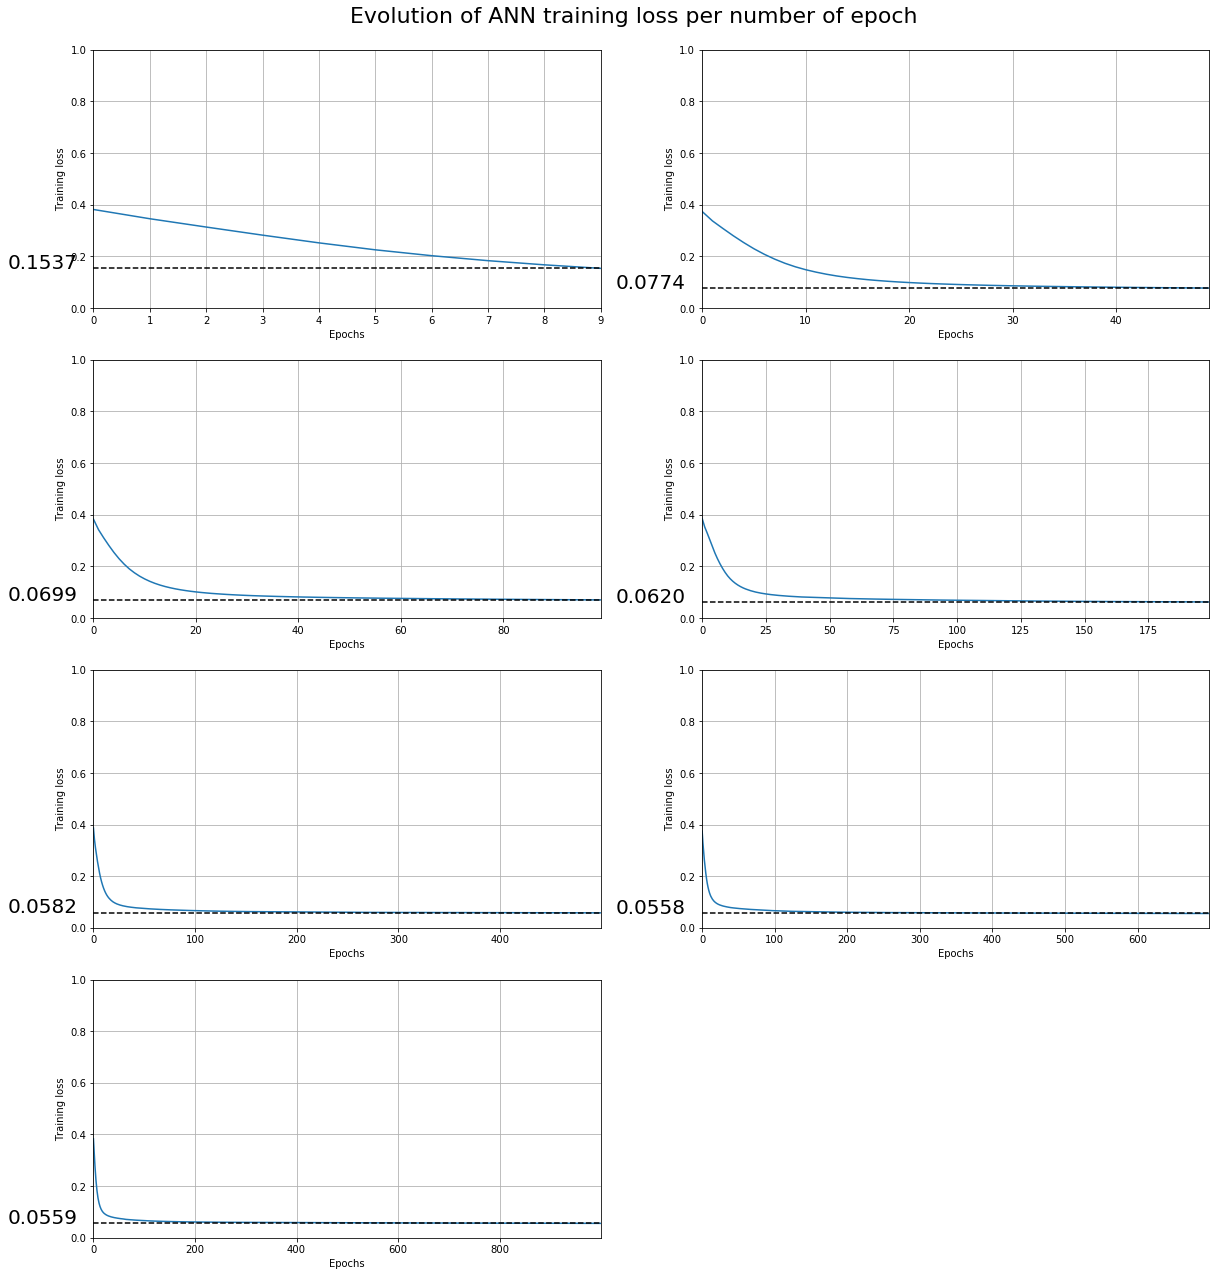

In [29]:
fig, (ax) = plt.subplots(4, 2, figsize=(20,20))
i=0
for ax_1 in ax:
    for ax_2 in ax_1:
        if i<7:
            training_loss = training_loss_per_num_epochs[i]
            ax_2.plot(training_loss)
            ax_2.plot(np.ones(len(training_loss))*training_loss[-1], color='k',linestyle = 'dashed')
            ax_2.set_xlim([0, len(training_loss)-1])
            ax_2.set_ylim([0, 1])
            ax_2.text(-0.17, training_loss[-1], "{:.4f}".format(training_loss[-1]), 
                      transform=ax_2.transAxes, size=20)
            ax_2.set_xlabel("Epochs")
            ax_2.set_ylabel("Training loss")
            ax_2.grid()
            i+=1
        else:
            ax_2.set_visible(False)
fig.subplots_adjust(top=0.95)
fig.suptitle("Evolution of ANN training loss per number of epoch", fontsize=22)
plt.show()

## 5.3.  Increasing the number of hidden nodes

In [11]:
# perform_per_num_nodes = pd.DataFrame(columns=["hidden nodes", "loss", "training acc (%)","test acc (%)"])
# perform_per_num_nodes

,hidden nodes,loss,training acc (%),test acc (%)


In [12]:
# epochs=500
# N_input = X_train.shape[1]
# N_output = y_train_one_hot.shape[1]
# LR = 0.0001
# batch_size=10

# for mul_layer in [2, 4, 10, 100, 200, 500]:
#     ann_model2 = Sequential()
#     ann_model2.add(Dense(N_input*mul_layer, input_dim=N_input, activation='relu'))
#     ann_model2.add(Dense(N_output, activation='softmax'))
#     optim = keras.optimizers.Adam(lr=LR)
#     ann_model2.compile(loss='binary_crossentropy', optimizer=optim, metrics=['accuracy']) # is binary_cross right?
#     history = ann_model2.fit(X_train, y_train_one_hot, epochs=epochs, batch_size=batch_size)
#     training_acc = history.history["accuracy"]
#     training_loss = history.history["loss"]

#     y_ann_pred = ann_model2.predict(X_test)
#     y_oh_pred = [[1 if pred == np.max(y_ann_pred[i]) else 0 for pred in y_ann_pred[i]] for i in range(len(y_ann_pred))]
#     y_pred_num = [y_oh_pred[i].index(1) for i in range(len(y_oh_pred))]
#     test_acc = accuracy_score(y_test_num, y_pred_num)*100

#     perform_per_num_nodes = perform_per_num_nodes.append({ 
#         "hidden nodes": str(int(N_input*mul_layer)), 
#         "loss": round(training_loss[-1], 4), 
#         "training acc (%)": round(training_acc[-1]*100, 2), 
#         "test acc (%)": round(test_acc, 2)},ignore_index = True)
#     ann_model2.save_weights(data_path + "ann3/weights/ann_trained_weights_h_nodes_"+str(int(N_input*mul_layer))+".h5")
#     np.save(data_path + "ann3/training accuracy/ann_training_acc_h_nodes_"+str(int(N_input*mul_layer)), history.history['accuracy'])
#     np.save(data_path + "ann3/training loss/ann_training_loss_h_nodes_"+str(int(N_input*mul_layer)), history.history['loss'])

Epoch 1/500
953/953 [==============================] - 1s 1ms/step - loss: 0.4025 - accuracy: 0.2041
Epoch 2/500
953/953 [==============================] - 1s 1ms/step - loss: 0.3652 - accuracy: 0.2797
Epoch 3/500
953/953 [==============================] - 1s 1ms/step - loss: 0.3365 - accuracy: 0.3681
Epoch 4/500
953/953 [==============================] - 1s 1ms/step - loss: 0.3058 - accuracy: 0.5658
Epoch 5/500
953/953 [==============================] - 1s 1ms/step - loss: 0.2760 - accuracy: 0.6985
Epoch 6/500
953/953 [==============================] - 1s 1ms/step - loss: 0.2488 - accuracy: 0.7596
Epoch 7/500
953/953 [==============================] - 1s 1ms/step - loss: 0.2247 - accuracy: 0.7937
Epoch 8/500
953/953 [==============================] - 1s 1ms/step - loss: 0.2037 - accuracy: 0.8248
Epoch 9/500
953/953 [==============================] - 1s 1ms/step - loss: 0.1857 - accuracy: 0.8466
Epoch 10/500
953/953 [==============================] - 1s 1ms/step - loss: 0.1700 - accura

953/953 [==============================] - 1s 1ms/step - loss: 0.0635 - accuracy: 0.9136
Epoch 160/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0635 - accuracy: 0.9143
Epoch 161/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0634 - accuracy: 0.9145
Epoch 162/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0634 - accuracy: 0.9136
Epoch 163/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0633 - accuracy: 0.9138
Epoch 164/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0632 - accuracy: 0.9150
Epoch 165/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0632 - accuracy: 0.9143
Epoch 166/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0631 - accuracy: 0.9140
Epoch 167/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0630 - accuracy: 0.9135
Epoch 168/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0630 - a

953/953 [==============================] - 1s 869us/step - loss: 0.0591 - accuracy: 0.9183
Epoch 318/500
953/953 [==============================] - 1s 885us/step - loss: 0.0591 - accuracy: 0.9173
Epoch 319/500
953/953 [==============================] - 1s 891us/step - loss: 0.0590 - accuracy: 0.9188
Epoch 320/500
953/953 [==============================] - 1s 869us/step - loss: 0.0591 - accuracy: 0.9185
Epoch 321/500
953/953 [==============================] - 1s 885us/step - loss: 0.0591 - accuracy: 0.9184
Epoch 322/500
953/953 [==============================] - 1s 869us/step - loss: 0.0590 - accuracy: 0.9177
Epoch 323/500
953/953 [==============================] - 1s 885us/step - loss: 0.0590 - accuracy: 0.9181
Epoch 324/500
953/953 [==============================] - 1s 869us/step - loss: 0.0590 - accuracy: 0.9183
Epoch 325/500
953/953 [==============================] - 1s 885us/step - loss: 0.0590 - accuracy: 0.9184
Epoch 326/500
953/953 [==============================] - 1s 885us/ste

953/953 [==============================] - 1s 1ms/step - loss: 0.0577 - accuracy: 0.9208
Epoch 475/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0576 - accuracy: 0.9208
Epoch 476/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0576 - accuracy: 0.9202
Epoch 477/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0577 - accuracy: 0.9199
Epoch 478/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0576 - accuracy: 0.9204
Epoch 479/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0576 - accuracy: 0.9200
Epoch 480/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0576 - accuracy: 0.9209
Epoch 481/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0576 - accuracy: 0.9199
Epoch 482/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0576 - accuracy: 0.9199
Epoch 483/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0575 - a

953/953 [==============================] - 1s 1ms/step - loss: 0.0607 - accuracy: 0.9163
Epoch 134/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0607 - accuracy: 0.9174
Epoch 135/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0605 - accuracy: 0.9168
Epoch 136/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0606 - accuracy: 0.9171
Epoch 137/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0604 - accuracy: 0.9182
Epoch 138/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0605 - accuracy: 0.9170
Epoch 139/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0604 - accuracy: 0.9182
Epoch 140/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0605 - accuracy: 0.9166
Epoch 141/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0604 - accuracy: 0.9166
Epoch 142/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0604 - a

Epoch 291/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0576 - accuracy: 0.9215
Epoch 292/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0576 - accuracy: 0.9213
Epoch 293/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0575 - accuracy: 0.9215
Epoch 294/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0574 - accuracy: 0.9217
Epoch 295/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0575 - accuracy: 0.9210
Epoch 296/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0575 - accuracy: 0.9206
Epoch 297/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0575 - accuracy: 0.9208
Epoch 298/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0575 - accuracy: 0.9214
Epoch 299/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0575 - accuracy: 0.9221
Epoch 300/500
953/953 [==============================] - 1s 1ms/step - lo

953/953 [==============================] - 1s 1ms/step - loss: 0.0559 - accuracy: 0.9240
Epoch 450/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0560 - accuracy: 0.9236
Epoch 451/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0560 - accuracy: 0.9237
Epoch 452/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0559 - accuracy: 0.9233
Epoch 453/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0560 - accuracy: 0.9223
Epoch 454/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0560 - accuracy: 0.9237
Epoch 455/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0559 - accuracy: 0.9239
Epoch 456/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0559 - accuracy: 0.9244
Epoch 457/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0559 - accuracy: 0.9252
Epoch 458/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0559 - a

953/953 [==============================] - 1s 1ms/step - loss: 0.0599 - accuracy: 0.9182
Epoch 108/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0601 - accuracy: 0.9184
Epoch 109/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0600 - accuracy: 0.9184
Epoch 110/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0599 - accuracy: 0.9189
Epoch 111/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0599 - accuracy: 0.9192
Epoch 112/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0597 - accuracy: 0.9185
Epoch 113/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0598 - accuracy: 0.9187
Epoch 114/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0597 - accuracy: 0.9193
Epoch 115/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0598 - accuracy: 0.9176
Epoch 116/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0596 - a

953/953 [==============================] - 1s 1ms/step - loss: 0.0566 - accuracy: 0.9225
Epoch 265/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0567 - accuracy: 0.9223
Epoch 266/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0567 - accuracy: 0.9220
Epoch 267/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0567 - accuracy: 0.9235
Epoch 268/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0567 - accuracy: 0.9220: 0s - los
Epoch 269/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0567 - accuracy: 0.9214
Epoch 270/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0566 - accuracy: 0.9225
Epoch 271/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0567 - accuracy: 0.9220
Epoch 272/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0566 - accuracy: 0.9227
Epoch 273/500
953/953 [==============================] - 1s 1ms/step - loss: 

953/953 [==============================] - 1s 1ms/step - loss: 0.0550 - accuracy: 0.9239
Epoch 421/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0549 - accuracy: 0.9247
Epoch 422/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0550 - accuracy: 0.9248
Epoch 423/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0550 - accuracy: 0.9245
Epoch 424/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0550 - accuracy: 0.9257
Epoch 425/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0550 - accuracy: 0.9263
Epoch 426/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0549 - accuracy: 0.9250
Epoch 427/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0547 - accuracy: 0.9248
Epoch 428/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0549 - accuracy: 0.9248
Epoch 429/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0549 - a

953/953 [==============================] - 1s 1ms/step - loss: 0.0573 - accuracy: 0.9201
Epoch 78/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0573 - accuracy: 0.9202
Epoch 79/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0574 - accuracy: 0.9214
Epoch 80/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0571 - accuracy: 0.9223
Epoch 81/500
953/953 [==============================] - 2s 2ms/step - loss: 0.0570 - accuracy: 0.9220
Epoch 82/500
953/953 [==============================] - 2s 2ms/step - loss: 0.0570 - accuracy: 0.9213
Epoch 83/500
953/953 [==============================] - 1s 2ms/step - loss: 0.0572 - accuracy: 0.9213
Epoch 84/500
953/953 [==============================] - 2s 2ms/step - loss: 0.0571 - accuracy: 0.9217
Epoch 85/500
953/953 [==============================] - 2s 2ms/step - loss: 0.0570 - accuracy: 0.9213
Epoch 86/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0571 - accuracy: 

953/953 [==============================] - 1s 1ms/step - loss: 0.0523 - accuracy: 0.9270
Epoch 236/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0521 - accuracy: 0.9275
Epoch 237/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0523 - accuracy: 0.9253
Epoch 238/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0517 - accuracy: 0.9284
Epoch 239/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0520 - accuracy: 0.9276
Epoch 240/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0521 - accuracy: 0.9279
Epoch 241/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0522 - accuracy: 0.9269
Epoch 242/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0522 - accuracy: 0.9283
Epoch 243/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0518 - accuracy: 0.9282
Epoch 244/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0518 - a

953/953 [==============================] - 1s 1ms/step - loss: 0.0499 - accuracy: 0.9287
Epoch 394/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0498 - accuracy: 0.9298
Epoch 395/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0498 - accuracy: 0.9319
Epoch 396/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0497 - accuracy: 0.9303
Epoch 397/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0497 - accuracy: 0.9297
Epoch 398/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0500 - accuracy: 0.9300
Epoch 399/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0497 - accuracy: 0.9294
Epoch 400/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0496 - accuracy: 0.9311
Epoch 401/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0496 - accuracy: 0.9305
Epoch 402/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0497 - a

953/953 [==============================] - 1s 2ms/step - loss: 0.0581 - accuracy: 0.9209
Epoch 53/500
953/953 [==============================] - 1s 2ms/step - loss: 0.0580 - accuracy: 0.9198
Epoch 54/500
953/953 [==============================] - 1s 2ms/step - loss: 0.0581 - accuracy: 0.9205
Epoch 55/500
953/953 [==============================] - 1s 2ms/step - loss: 0.0579 - accuracy: 0.9194
Epoch 56/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0580 - accuracy: 0.9198
Epoch 57/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0578 - accuracy: 0.9212
Epoch 58/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0579 - accuracy: 0.9200
Epoch 59/500
953/953 [==============================] - 1s 2ms/step - loss: 0.0576 - accuracy: 0.9201
Epoch 60/500
953/953 [==============================] - 1s 2ms/step - loss: 0.0577 - accuracy: 0.9208
Epoch 61/500
953/953 [==============================] - 1s 2ms/step - loss: 0.0577 - accuracy: 

953/953 [==============================] - 1s 2ms/step - loss: 0.0539 - accuracy: 0.9252
Epoch 133/500
953/953 [==============================] - 1s 2ms/step - loss: 0.0538 - accuracy: 0.9259
Epoch 134/500
953/953 [==============================] - 1s 2ms/step - loss: 0.0539 - accuracy: 0.9250
Epoch 135/500
953/953 [==============================] - 1s 2ms/step - loss: 0.0542 - accuracy: 0.9254
Epoch 136/500
953/953 [==============================] - 1s 2ms/step - loss: 0.0537 - accuracy: 0.9277
Epoch 137/500
953/953 [==============================] - 1s 2ms/step - loss: 0.0535 - accuracy: 0.9253
Epoch 138/500
953/953 [==============================] - 1s 2ms/step - loss: 0.0537 - accuracy: 0.9257
Epoch 139/500
953/953 [==============================] - 1s 2ms/step - loss: 0.0535 - accuracy: 0.9250
Epoch 140/500
953/953 [==============================] - 1s 2ms/step - loss: 0.0537 - accuracy: 0.9238
Epoch 141/500
953/953 [==============================] - 2s 2ms/step - loss: 0.0534 - a

953/953 [==============================] - 1s 2ms/step - loss: 0.0500 - accuracy: 0.9315
Epoch 291/500
953/953 [==============================] - 1s 2ms/step - loss: 0.0497 - accuracy: 0.9312
Epoch 292/500
953/953 [==============================] - 1s 2ms/step - loss: 0.0503 - accuracy: 0.9300: 0s
Epoch 293/500
953/953 [==============================] - 1s 2ms/step - loss: 0.0500 - accuracy: 0.9305
Epoch 294/500
953/953 [==============================] - 1s 1ms/step - loss: 0.0501 - accuracy: 0.9287
Epoch 295/500
953/953 [==============================] - 1s 2ms/step - loss: 0.0505 - accuracy: 0.9282
Epoch 296/500
953/953 [==============================] - 1s 2ms/step - loss: 0.0499 - accuracy: 0.9288
Epoch 297/500
953/953 [==============================] - 1s 2ms/step - loss: 0.0498 - accuracy: 0.9301
Epoch 298/500
953/953 [==============================] - 1s 2ms/step - loss: 0.0499 - accuracy: 0.9293
Epoch 299/500
953/953 [==============================] - 1s 2ms/step - loss: 0.0500

953/953 [==============================] - 1s 2ms/step - loss: 0.0495 - accuracy: 0.9314
Epoch 370/500
953/953 [==============================] - 1s 2ms/step - loss: 0.0490 - accuracy: 0.9327
Epoch 371/500
953/953 [==============================] - 1s 2ms/step - loss: 0.0492 - accuracy: 0.9290
Epoch 372/500
953/953 [==============================] - 1s 2ms/step - loss: 0.0488 - accuracy: 0.9322
Epoch 373/500
953/953 [==============================] - 1s 2ms/step - loss: 0.0494 - accuracy: 0.9304
Epoch 374/500
953/953 [==============================] - 1s 2ms/step - loss: 0.0494 - accuracy: 0.9306
Epoch 375/500
953/953 [==============================] - 1s 2ms/step - loss: 0.0489 - accuracy: 0.9324
Epoch 376/500
953/953 [==============================] - 1s 2ms/step - loss: 0.0491 - accuracy: 0.9316
Epoch 377/500
953/953 [==============================] - 1s 2ms/step - loss: 0.0493 - accuracy: 0.9302
Epoch 378/500
953/953 [==============================] - 1s 2ms/step - loss: 0.0493 - a

953/953 [==============================] - 2s 2ms/step - loss: 0.0595 - accuracy: 0.9179
Epoch 29/500
953/953 [==============================] - 2s 2ms/step - loss: 0.0595 - accuracy: 0.9192
Epoch 30/500
953/953 [==============================] - 2s 2ms/step - loss: 0.0592 - accuracy: 0.9187
Epoch 31/500
953/953 [==============================] - 2s 2ms/step - loss: 0.0592 - accuracy: 0.9160
Epoch 32/500
953/953 [==============================] - 2s 2ms/step - loss: 0.0589 - accuracy: 0.9176
Epoch 33/500
953/953 [==============================] - 2s 2ms/step - loss: 0.0587 - accuracy: 0.9202
Epoch 34/500
953/953 [==============================] - 2s 2ms/step - loss: 0.0589 - accuracy: 0.9179
Epoch 35/500
953/953 [==============================] - 2s 2ms/step - loss: 0.0587 - accuracy: 0.9173
Epoch 36/500
953/953 [==============================] - 2s 2ms/step - loss: 0.0587 - accuracy: 0.9176
Epoch 37/500
953/953 [==============================] - 2s 2ms/step - loss: 0.0588 - accuracy: 

953/953 [==============================] - 2s 2ms/step - loss: 0.0512 - accuracy: 0.9285
Epoch 188/500
953/953 [==============================] - 2s 2ms/step - loss: 0.0508 - accuracy: 0.9276
Epoch 189/500
953/953 [==============================] - 2s 2ms/step - loss: 0.0510 - accuracy: 0.9280
Epoch 190/500
953/953 [==============================] - 2s 2ms/step - loss: 0.0513 - accuracy: 0.9276
Epoch 191/500
953/953 [==============================] - 2s 2ms/step - loss: 0.0510 - accuracy: 0.9287
Epoch 192/500
953/953 [==============================] - 2s 2ms/step - loss: 0.0510 - accuracy: 0.9275
Epoch 193/500
953/953 [==============================] - 2s 2ms/step - loss: 0.0507 - accuracy: 0.9296
Epoch 194/500
953/953 [==============================] - 2s 2ms/step - loss: 0.0510 - accuracy: 0.9270
Epoch 195/500
953/953 [==============================] - 2s 2ms/step - loss: 0.0508 - accuracy: 0.9307
Epoch 196/500
953/953 [==============================] - 2s 2ms/step - loss: 0.0508 - a

953/953 [==============================] - 2s 2ms/step - loss: 0.0489 - accuracy: 0.9322
Epoch 346/500
953/953 [==============================] - 2s 2ms/step - loss: 0.0482 - accuracy: 0.9315
Epoch 347/500
953/953 [==============================] - 2s 2ms/step - loss: 0.0486 - accuracy: 0.9305
Epoch 348/500
953/953 [==============================] - 2s 2ms/step - loss: 0.0485 - accuracy: 0.9315
Epoch 349/500
953/953 [==============================] - 2s 2ms/step - loss: 0.0486 - accuracy: 0.9304
Epoch 350/500
953/953 [==============================] - 2s 2ms/step - loss: 0.0484 - accuracy: 0.9318
Epoch 351/500
953/953 [==============================] - 2s 2ms/step - loss: 0.0484 - accuracy: 0.9307
Epoch 352/500
953/953 [==============================] - 2s 2ms/step - loss: 0.0483 - accuracy: 0.9336
Epoch 353/500
953/953 [==============================] - 2s 2ms/step - loss: 0.0485 - accuracy: 0.9311
Epoch 354/500
953/953 [==============================] - 2s 2ms/step - loss: 0.0483 - a

In [13]:
perform_per_num_nodes

,hidden nodes,loss,training acc (%),test acc (%)
0,32,0.0575,92.08,92.38
1,64,0.0554,92.43,92.56
2,160,0.0543,92.48,92.43
3,1600,0.0488,93.17,92.92
4,3200,0.0479,93.39,92.80
5,8000,0.0467,93.27,93.22


##### Visualizing the performances

In [30]:
perform_per_h_nodes = pd.DataFrame(columns=["hidden nodes", "loss", "training acc (%)","test acc (%)"])
training_acc_per_h_nodes = []
training_loss_per_h_nodes = []

In [31]:
N_input = X_train.shape[1]
N_output = y_train_one_hot.shape[1]
LR = 0.0001
for mul_layer in [2, 4, 10, 100, 200, 500]:
    ann_model3 = Sequential()
    ann_model3.add(Dense(N_input*mul_layer, input_dim=N_input, activation='relu'))
    ann_model3.add(Dense(N_output, activation='softmax'))
    optim = keras.optimizers.Adam(lr=LR)
    ann_model3.compile(loss='binary_crossentropy', optimizer=optim, metrics=['accuracy'])
    ann_model3.load_weights(data_path + "ann3/weights/ann_trained_weights_h_nodes_"+str(N_input*mul_layer)+".h5")
    training_acc = np.load(data_path + "ann3/training accuracy/ann_training_acc_h_nodes_"+str(N_input*mul_layer)+".npy")
    training_loss = np.load(data_path + "ann3/training loss/ann_training_loss_h_nodes_"+str(N_input*mul_layer)+".npy")
    training_acc_per_h_nodes.append(training_acc)
    training_loss_per_h_nodes.append(training_loss)
    y_ann_pred = ann_model3.predict(X_test)
    y_oh_pred = [[1 if pred == np.max(y_ann_pred[i]) else 0 for pred in y_ann_pred[i]] for i in range(len(y_ann_pred))]
    y_pred_num = [y_oh_pred[i].index(1) for i in range(len(y_oh_pred))]
    test_acc = accuracy_score(y_test_num, y_pred_num)*100

    perform_per_h_nodes = perform_per_h_nodes.append({ 
        "hidden nodes": str(int(N_input*mul_layer)), 
        "loss": round(training_loss[-1], 4), 
        "training acc (%)": round(training_acc[-1]*100, 2), 
        "test acc (%)": round(test_acc, 2)},ignore_index = True)
perform_per_h_nodes

,hidden nodes,loss,training acc (%),test acc (%)
0,32,0.0575,92.08,92.38
1,64,0.0554,92.43,92.56
2,160,0.0543,92.48,92.43
3,1600,0.0488,93.17,92.92
4,3200,0.0479,93.39,92.80
5,8000,0.0467,93.27,93.22


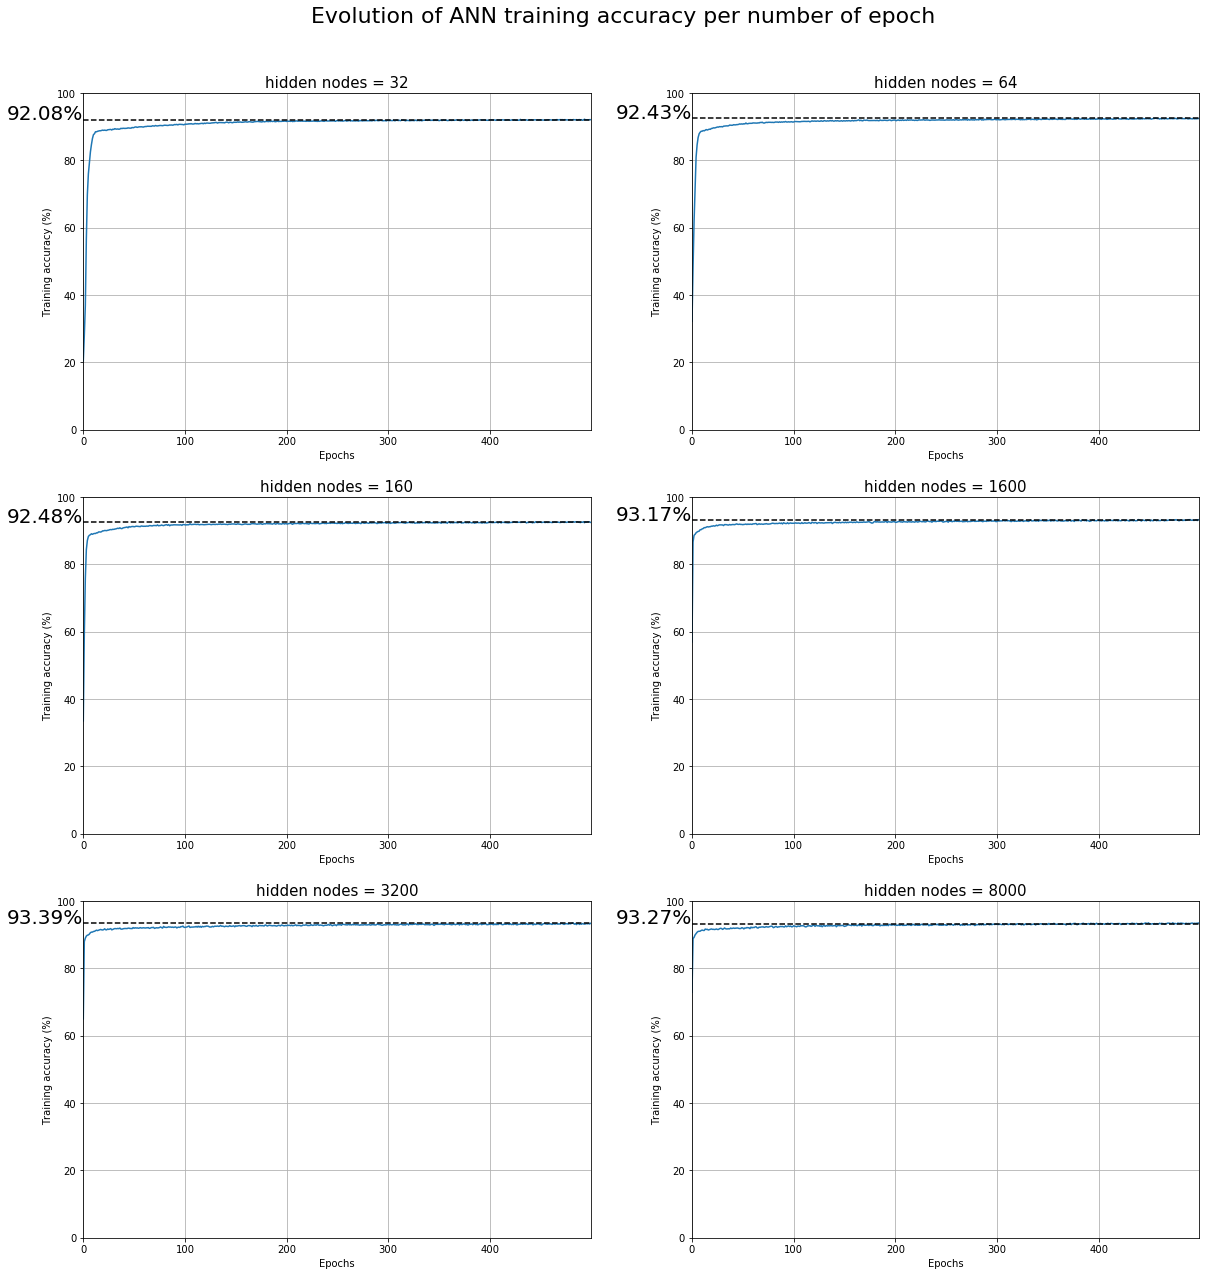

In [41]:
fig, (ax) = plt.subplots(3, 2, figsize=(20,20))
i=0
h_layer = np.array([2, 4, 10, 100, 200, 500])*N_input
for ax_1 in ax:
    for ax_2 in ax_1:
        training_acc = training_acc_per_h_nodes[i]
        ax_2.plot(training_acc*100)
        ax_2.plot(np.ones(len(training_acc))*training_acc[-1]*100, color='k',linestyle = 'dashed')
        ax_2.set_xlim([0, len(training_acc)-1])
        ax_2.set_ylim([0, 100])
        ax_2.text(-0.15, training_acc[-1], "{:.2f}".format(training_acc[-1]*100)+"%", 
                  transform=ax_2.transAxes, size=20)
        ax_2.set_xlabel("Epochs")
        ax_2.set_ylabel("Training accuracy (%)")
        ax_2.set_title('hidden nodes = '+str(h_layer[i]), fontsize=15)
        ax_2.grid()
        i+=1
fig.subplots_adjust(top=0.92)
fig.suptitle("Evolution of ANN training accuracy per number of epoch", fontsize=22)
plt.show()

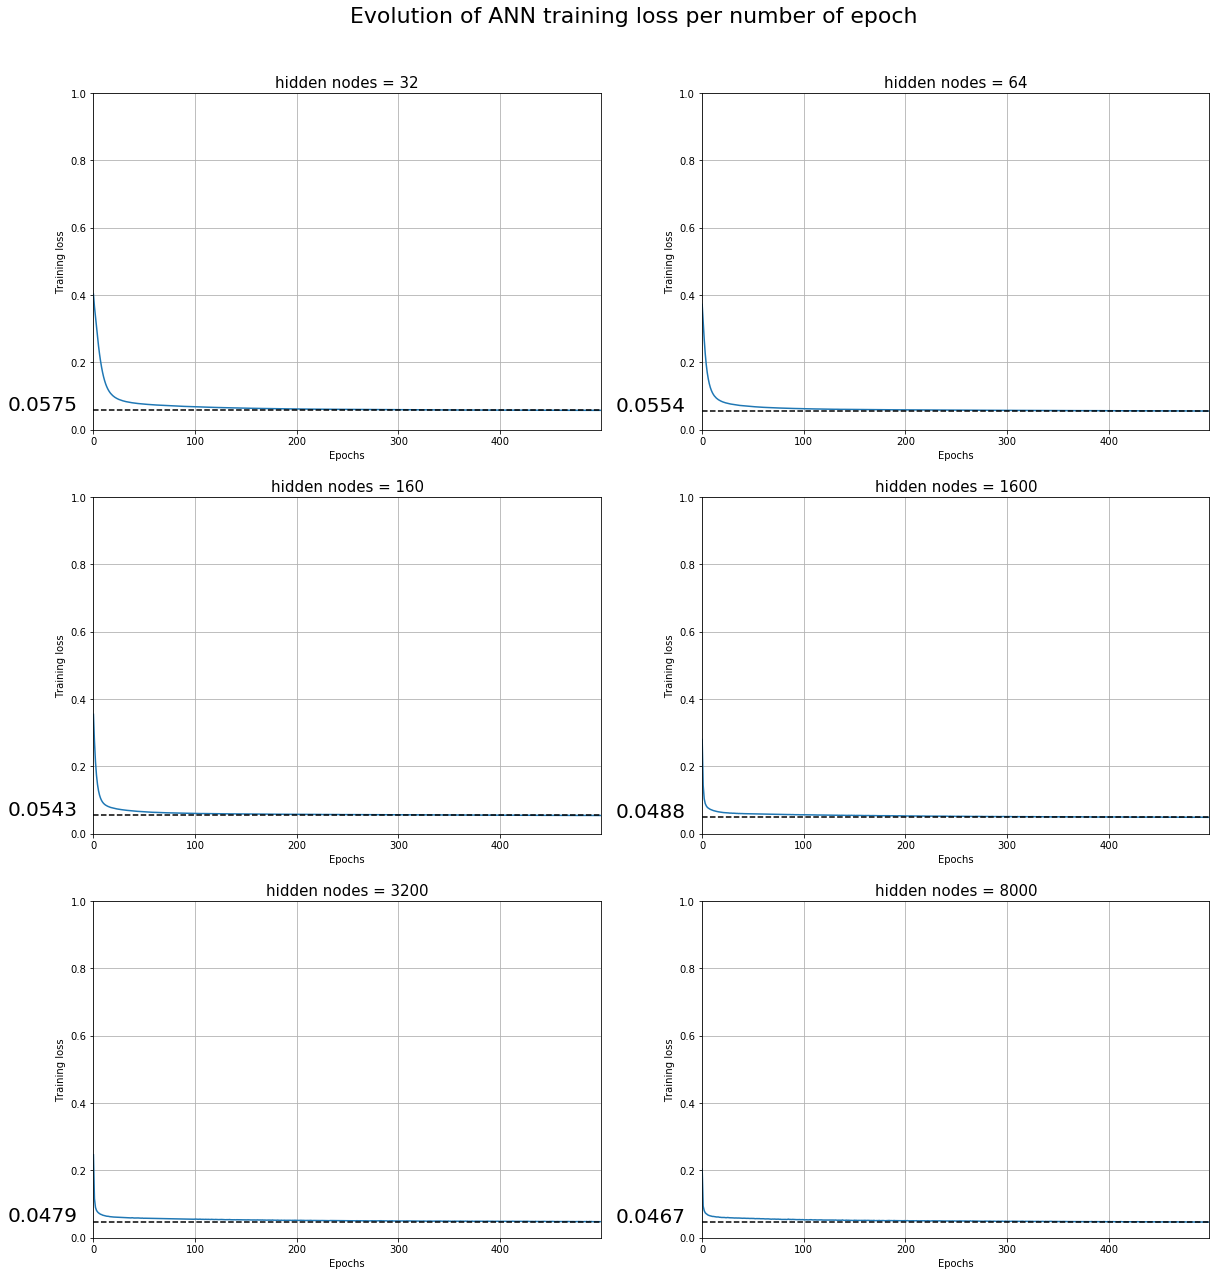

In [40]:
fig, (ax) = plt.subplots(3, 2, figsize=(20,20))
i=0
h_layer = np.array([2, 4, 10, 100, 200, 500])*N_input
for ax_1 in ax:
    for ax_2 in ax_1:
        training_loss = training_loss_per_h_nodes[i]
        ax_2.plot(training_loss)
        ax_2.plot(np.ones(len(training_loss))*training_loss[-1], color='k',linestyle = 'dashed')
        ax_2.set_xlim([0, len(training_loss)-1])
        ax_2.set_ylim([0, 1])
        ax_2.text(-0.17, training_loss[-1], "{:.4f}".format(training_loss[-1]), 
                  transform=ax_2.transAxes, size=20)
        ax_2.set_xlabel("Epochs")
        ax_2.set_ylabel("Training loss")
        ax_2.set_title('hidden nodes = '+str(h_layer[i]), fontsize=15)
        ax_2.grid()
        i+=1
fig.subplots_adjust(top=0.92)
fig.suptitle("Evolution of ANN training loss per number of epoch", fontsize=22)
plt.show()

# 6. Deep Neural Network Classification

## 6.1. Building the network

In [ ]:
# dnn_model = Sequential()
# dnn_model.add(Dense(N_input*500, input_dim=N_input, activation='relu'))
# dnn_model.add(Dense(N_input*500, input_dim=N_input, activation='relu'))
# dnn_model.add(Dense(N_input*500, input_dim=N_input, activation='relu'))
# dnn_model.add(Dense(N_input*500, input_dim=N_input, activation='relu'))
# dnn_model.add(Dense(N_input*500, input_dim=N_input, activation='relu'))
# dnn_model.add(Dense(N_input*500, input_dim=N_input, activation='relu'))
# dnn_model.add(Dense(N_input*500, input_dim=N_input, activation='relu'))
# dnn_model.add(Dense(N_output, activation='softmax'))

# optim = keras.optimizers.Adam(lr=LR)
# dnn_model.compile(loss='binary_crossentropy', optimizer=optim, metrics=['accuracy']) # is binary_cross right?
# dnn_model.summary()

# # saving the weights
# dnn_model.save_weights(data_path + "dnn2 data/weights/dnn_initial_weights.h5")

In [73]:
def get_dnn(N_input, N_output, LR, num_hidden_layers):
    dnn_model = Sequential()
    for i in range(num_hidden_layers-1):
        dnn_model.add(Dense(1600, input_dim=N_input, activation='relu'))
    dnn_model.add(Dense(N_output, activation='softmax'))
    optim = keras.optimizers.Adam(lr=LR)
    dnn_model.compile(loss='binary_crossentropy', optimizer=optim, metrics=['accuracy'])
    return dnn_model

In [74]:
LR = 0.0001
N_input = X_train.shape[1]
N_output = y_train_one_hot.shape[1]

## 6.2. Training the network

In [75]:
# explain epochs
epochs=500
batch_size=10

In [76]:
perform_per_num_h_layers = pd.DataFrame(columns=["hidden layers", "loss", "training acc (%)","test acc (%)"])
perform_per_num_h_layers

,hidden layers,loss,training acc (%),test acc (%)


In [77]:
for h_layers in [2, 4, 10, 50, 100]:
    dnn_model = get_dnn(N_input, N_output, LR, h_layers)
    history = dnn_model.fit(X_train, y_train_one_hot, epochs=epochs, batch_size=batch_size)
    training_acc = history.history["accuracy"]
    training_loss = history.history["loss"]

    y_ann_pred = dnn_model.predict(X_test)
    y_oh_pred = [[1 if pred == np.max(y_ann_pred[i]) else 0 for pred in y_ann_pred[i]] for i in range(len(y_ann_pred))]
    y_pred_num = [y_oh_pred[i].index(1) for i in range(len(y_oh_pred))]
    test_acc = accuracy_score(y_test_num, y_pred_num)*100

    perform_per_num_h_layers = perform_per_num_h_layers.append({ 
        "hidden layers": str(int(h_layers)), 
        "loss": round(training_loss[-1], 4), 
        "training acc (%)": round(training_acc[-1]*100, 2), 
        "test acc (%)": round(test_acc, 2)},ignore_index = True)
    dnn_model.save_weights(data_path + "dnn2/weights/ann_trained_weights_h_layers_"+str(int(h_layers))+".h5")
    np.save(data_path + "dnn2/training accuracy/ann_training_acc_h_layers_"+str(int(h_layers)), history.history['accuracy'])
    np.save(data_path + "dnn2/training loss/ann_training_loss_h_layers_"+str(int(h_layers)), history.history['loss'])
    # save weights after training
    dnn_model.save_weights(data_path + "dnn2/weights/dnn_trained_weights_h_layers_"+str(h_layers)+".h5")
    np.save(data_path + "dnn2/training accuracy/dnn_training_acc_h_layers_"+str(h_layers), history.history['accuracy'])
    np.save(data_path + "dnn2/training loss/dnn_training_lossh_layers_"+str(h_layers), history.history['loss'])

Epoch 1/500
953/953 [==============================] - 22s 23ms/step - loss: 0.1354 - accuracy: 0.8200
Epoch 2/500
953/953 [==============================] - 21s 22ms/step - loss: 0.0731 - accuracy: 0.9005
Epoch 3/500
953/953 [==============================] - 21s 22ms/step - loss: 0.0674 - accuracy: 0.9074
Epoch 4/500
953/953 [==============================] - 22s 23ms/step - loss: 0.0661 - accuracy: 0.9110
Epoch 5/500
953/953 [==============================] - 22s 23ms/step - loss: 0.0641 - accuracy: 0.9090
Epoch 6/500
953/953 [==============================] - 21s 22ms/step - loss: 0.0632 - accuracy: 0.9115
Epoch 7/500
953/953 [==============================] - 21s 22ms/step - loss: 0.0625 - accuracy: 0.9146
Epoch 8/500
953/953 [==============================] - 20s 21ms/step - loss: 0.0614 - accuracy: 0.9143
Epoch 9/500
953/953 [==============================] - 20s 21ms/step - loss: 0.0616 - accuracy: 0.9148
Epoch 10/500
953/953 [==============================] - 24s 25ms/step - l

953/953 [==============================] - 22s 23ms/step - loss: 0.0457 - accuracy: 0.9351
Epoch 157/500
953/953 [==============================] - 22s 23ms/step - loss: 0.0457 - accuracy: 0.9339
Epoch 158/500
953/953 [==============================] - 22s 23ms/step - loss: 0.0450 - accuracy: 0.9348
Epoch 159/500
953/953 [==============================] - 22s 23ms/step - loss: 0.0458 - accuracy: 0.9327
Epoch 160/500
953/953 [==============================] - 22s 23ms/step - loss: 0.0449 - accuracy: 0.9350
Epoch 161/500
953/953 [==============================] - 22s 23ms/step - loss: 0.0444 - accuracy: 0.9378
Epoch 162/500
953/953 [==============================] - 22s 23ms/step - loss: 0.0453 - accuracy: 0.9367
Epoch 163/500
953/953 [==============================] - 22s 23ms/step - loss: 0.0448 - accuracy: 0.9361
Epoch 164/500
953/953 [==============================] - 22s 23ms/step - loss: 0.0447 - accuracy: 0.9362
Epoch 165/500
953/953 [==============================] - 22s 23ms/ste

953/953 [==============================] - 22s 23ms/step - loss: 0.0374 - accuracy: 0.9451
Epoch 310/500
953/953 [==============================] - 22s 23ms/step - loss: 0.0370 - accuracy: 0.9467
Epoch 311/500
953/953 [==============================] - 22s 23ms/step - loss: 0.0371 - accuracy: 0.9464
Epoch 312/500
953/953 [==============================] - 22s 23ms/step - loss: 0.0363 - accuracy: 0.9465
Epoch 313/500
953/953 [==============================] - 22s 23ms/step - loss: 0.0366 - accuracy: 0.94790s - loss: 0.0
Epoch 314/500
953/953 [==============================] - 22s 23ms/step - loss: 0.0369 - accuracy: 0.9462
Epoch 315/500
953/953 [==============================] - 22s 23ms/step - loss: 0.0364 - accuracy: 0.9471
Epoch 316/500
953/953 [==============================] - 22s 23ms/step - loss: 0.0372 - accuracy: 0.9471
Epoch 317/500
953/953 [==============================] - 22s 23ms/step - loss: 0.0368 - accuracy: 0.9459
Epoch 318/500
953/953 [==============================] 

953/953 [==============================] - 22s 23ms/step - loss: 0.0289 - accuracy: 0.9574
Epoch 462/500
953/953 [==============================] - 22s 23ms/step - loss: 0.0288 - accuracy: 0.9573
Epoch 463/500
953/953 [==============================] - 22s 23ms/step - loss: 0.0288 - accuracy: 0.9584
Epoch 464/500
953/953 [==============================] - 22s 23ms/step - loss: 0.0290 - accuracy: 0.95690s - loss: 0.0290 - ac
Epoch 465/500
953/953 [==============================] - 22s 23ms/step - loss: 0.0294 - accuracy: 0.9552
Epoch 466/500
953/953 [==============================] - 22s 23ms/step - loss: 0.0289 - accuracy: 0.9569
Epoch 467/500
953/953 [==============================] - 22s 24ms/step - loss: 0.0282 - accuracy: 0.9583
Epoch 468/500
953/953 [==============================] - 22s 23ms/step - loss: 0.0287 - accuracy: 0.95820s - loss: 0.0286 - accura
Epoch 469/500
953/953 [==============================] - 22s 23ms/step - loss: 0.0287 - accuracy: 0.9582
Epoch 470/500
953/953

KeyboardInterrupt: 

In [ ]:
perform_per_num_h_layers

## 6.3. Plotting training performance

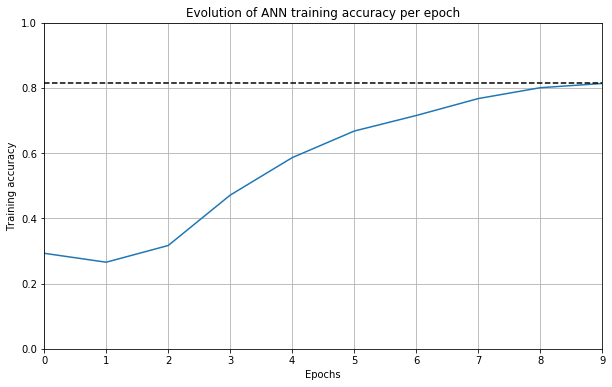

In [51]:
training_acc = history_dnn.history['accuracy']
plt.figure(figsize=(10,6))
plt.plot(training_acc)
plt.plot(np.ones(len(training_acc))*training_acc[-1], color='k',linestyle = 'dashed')
plt.xlim([0, epochs-1])
plt.ylim([0, 1])
plt.xlabel("Epochs")
plt.ylabel("Training accuracy")
plt.title("Evolution of DNN training accuracy per epoch")
plt.grid()
plt.show()

## 6.4. Testing the network

##### a. Getting the prediction array

In [208]:
# dnn_model.save_weights(data_path + "data/dnn_trained_weights.h5")
y_dnn_pred = dnn_model.predict(X_test)

##### b. Normalizing the prediction array

In [209]:
y_oh_pred = []
for i in range(len(y_dnn_pred)):
    pred = y_dnn_pred[i]
    pred_max = np.max(y_dnn_pred[i])
    y_oh_pred.append(list(np.where(pred== pred_max, 1, 0)))
# y_oh_pred = np.array(y_oh_pred)
# using list comprehension
# y_oh_pred = [[1 if pred == np.max(y_dnn_pred[i]) else 0 for pred in y_dnn_pred[i]] for i in range(len(y_dnn_pred))]
# y_oh_pred = np.array(y_oh_pred)

##### b. Decoding the one-hot prediction array and displaying the accuracy report

In [210]:
y_pred_num = [y_oh_pred[i].index(1) for i in range(len(y_oh_pred))]
acc_report = accuracy_report(y_test_num, y_pred_num)

for key in acc_report:
    print(key, " = ", "{:.2f}".format(acc_report[key]), " %")

class 0  =  93.43  %
class 1  =  100.00  %
class 2  =  93.91  %
class 3  =  93.41  %
class 4  =  94.58  %
class 5  =  93.86  %
class 6  =  87.56  %
OA  =  92.78  %
AA  =  93.82  %


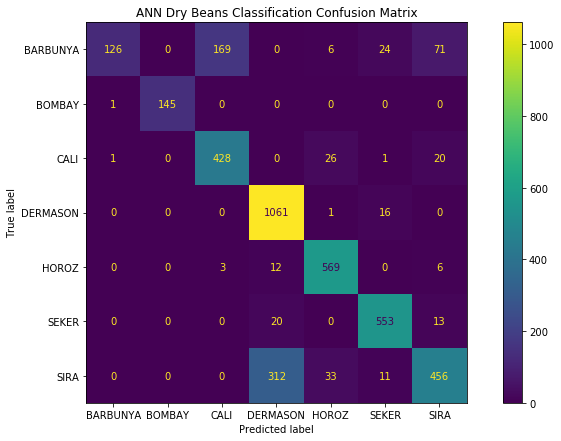

In [105]:
y_pred = encoder.inverse_transform(y_pred_num)
cm = confusion_matrix(y_test,y_pred)
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=np.unique(y))
_, ax = plt.subplots(figsize=(13, 7))
disp.plot(ax=ax)
plt.title("DNN Dry Beans Classification Confusion Matrix")
plt.show()